# Score Matrix

Use model to generate confusion matrix



In [1]:
import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import numpy as np
#import psutil
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
#from tqdm import tqdm
from PIL import Image
from data_loader import (
    TRAIN_DIR,
    VALID_DIR,
    augment_and_save,
    data_distribution,
    imagenet_stats,
    img_transforms,
    plot_data_distribution,
    show_data,
)
sns.set_theme(style="whitegrid", palette="husl")

/home/u103128/.conda/envs/PT3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/u103128/.conda/envs/PT3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
2023-08-09 14:43:59,751 - numexpr.utils - INFO - Note: detected 224 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2023-08-09 14:43:59,752 - numexpr.utils - INFO - Note: NumExpr detected 224 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-08-09 14:43:59,752 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


Device set to xpu by user.
OMP_NUM_THREADS set to: 112


# Specify Model to test

In [2]:
# simple = False
# epochs = 12
# ipx = True 
# dropout = .5
# batch_size = 128
# # bc_resnet18_simpleFalse_IPEXTrue_Epochs12_dropout0.4_batch128
# model_name = "ON_resnet18_simpleFalse_IPEXTrue_Epochs40_dropout0.33_batch128"
# #resnet18_simpleFalse_IPEXTrue_Epochs12_dropout0.4_batch128
# #model_name = f"resnet18_simple{simple}_IPEX{ipx}_Epochs{epochs}_dropout{dropout}_batch{batch_size}"
# print(model_name)
# model_read = torch.jit.load(f"models/{model_name}.pt")

# model_read.eval()

# Define Predict Function

In [3]:
def predict(InFldr, ScoreDict, model):
    import torchvision.transforms as transforms
    import torch.nn as nn
    import glob 
    model.eval()

    scores = []
    fns = []
    transform = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats),
    ])
    
    for fn in glob.glob(TEST_DIR+'*.png'):
        img = Image.open(fn)
        img_tensor = transform(img).reshape(1, 3, 1024, 1024)
        score = 0
        modelCPU = model.to("cpu")
        score = np.argmax(torch.softmax( modelCPU(img_tensor).detach(), dim =1).numpy().squeeze())
        fns.append(fn)
        scores.append(ScoreDict[score])
    return (scores, fns)
# model.eval()
# with torch.no_grad():
#     model_scripted = torch.jit.script(model.to("cpu"))  # Export to TorchScript
#     model_scripted.save(model_save_path)  # Jit Save

In [4]:
#model_save_path
model_name = f"models/model_acc_84_device_xpu_lr_0.000214_epochs_20_jit.pt"
print(model_name)

model_read = torch.jit.load(model_name)
#model_read.eval()

models/model_acc_84_device_xpu_lr_0.000214_epochs_20_jit.pt


# Scoring individual images with model
### Known Fire

In [5]:
Fire_true = []
Fire_pred = []
Fire_pred_dict = {}
TEST_DIR =  'data/colorEnhanced/val/Fire/'
scoreDict = {0:'Fire', 1:'NoFire'}
scores, fns = predict(TEST_DIR, scoreDict, model_read)
for score, fn in zip(scores, fns):
    Fire_pred_dict[fn] = score
    print(f"{score}\t{fn}")
    if score == 'Fire': 
        Fire_pred.append(1)
    else:
        Fire_pred.append(0)
    Fire_true.append(1)

Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_mid-day_signs_of_wild_fire_8.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_mid-day_signs_of_wild_fire_11.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_late_afternoon_with_signs_of_wild_fire,_no_clouds_10.png
NoFire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_early_morning_with_a_wild_fire,_no_clouds_0.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_early_morning_with_a_wild_fire_0.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_night_with_wild_fire_3.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_early_morning_with_a_wild_fire,_no_clouds_3.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_mid-day_signs_of_wild_fire_14.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_early_morning_with_a_wild_fire,_no_clouds_6.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_mid-day_signs_of_wild_fire_17.pn

# Scoring individual images with model
### Known NoFire

# Define functions and normalization parameters

In [6]:
TEST_DIR =  'data/colorEnhanced/val/NoFire/'
scoreDict = {0:'Fire', 1:'NoFire'}
scores, fns = predict(TEST_DIR, scoreDict, model_read)
for score, fn in zip(scores, fns):
    Fire_pred_dict[fn] = score
    print(f"{score}\t{fn}")
    if score == 'Fire': 
        Fire_pred.append(1)
    else:
        Fire_pred.append(0)
    Fire_true.append(0)
len(Fire_pred)

NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_dense_vegetation_without_any_signs_of_a_wild_fire_3.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_late_afternoon_with_clear_skies_with_no_signs_of_wild_fire_1.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_mid-day_with_clear_skies_with_no_signs_of_wild_fire_7.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_sparse_vegetation_no_signs_of_wild_fire_9.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_early_morning_with_clear_skies_0.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_late_afternoon_with_clear_skies_with_no_signs_of_wild_fire_11.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_dense_vegetation_without_any_signs_of_a_wild_fire_8.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_late_afternoon_with_clear_skies_with_no_signs_of_wild_fire_16.png
NoFire	data/colorEnhanced/val/NoFire/m

50

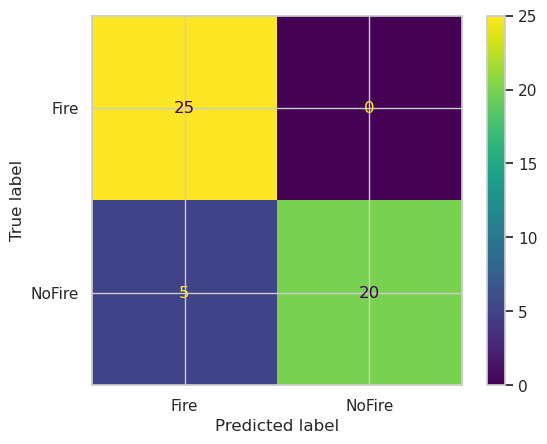

In [7]:
%matplotlib inline
fireDict = {0:'Fire', 1:'NoFire'}
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
YTRUE = [fireDict[val] for val in Fire_true]
YPRED = [fireDict[val] for val in Fire_pred]
labels=['Fire', 'NoFire']
cm = confusion_matrix(YTRUE, YPRED,  labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.show()

In [8]:
import pandas as pd
import numpy as np

usgs = pd.read_csv('data/USGS_NAIP_Sampled_Mapping.csv')
usgs['Longitude'] = usgs['Centroid'].apply(lambda x: float(x.split('(')[-1].replace(')','').replace(' ','').split(',')[0]))
usgs['Lattitude'] = usgs['Centroid'].apply(lambda x: float(x.split('(')[-1].replace(')','').replace(' ','').split(',')[1]))

# ModisOutlineParadise = np.load('data/ModisOutlineParadise.npy')
# ModisOutlineNorth = np.load('data/ModisOutlineNorth.npy')
# ModisOutlineWest = np.load('data/ModisOutlineWest.npy' )

In [9]:
#Fire_pred_dict
colorEnhancedMap = pd.read_csv("data/ColorEnhanced_Mapping.csv")
colorEnhancedMap = colorEnhancedMap.drop(columns=['Unnamed: 0'])
colorEnhancedMap

,Long,Lat,Class,Name
0,-120.257504,39.631237,NoFire,m_3912142_sw_10_h_20160711_dense_vegetation_wi...
1,-120.807978,39.746529,NoFire,m_3912343_se_10_h_20160529_no_signs_of_fire_1.png
2,-123.753879,40.991261,NoFire,m_3912142_sw_10_h_20160711_sparse_vegetation_n...
3,-120.373237,40.969949,NoFire,m_3912057_sw_10_h_20160711_early_morning_with_...
4,-121.106805,40.830038,NoFire,m_3912057_sw_10_h_20160711_sparse_vegetation_n...
...,...,...,...,...
245,-121.813154,39.510351,Fire,m_4012355_se_10_h_20160713_late_afternoon_with...
246,-121.752525,39.758801,Fire,m_4012355_se_10_h_20160713_late_afternoon_with...
247,-122.064563,40.041826,Fire,m_4012355_se_10_h_20160713_early_morning_with_...
248,-121.072849,40.015871,Fire,m_4012355_se_10_h_20160713_early_morning_with_...


# Synthesize and a Faux MODIS Burn Area

sample N coordinates within and without the polygon

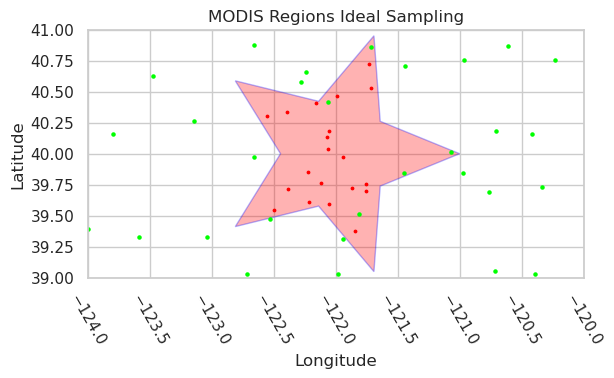

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as GPoly
from shapely.geometry import Point
import random

fig, ax = plt.subplots()

N_rnd = 2000

xrnd = 4*np.random.sample(N_rnd) - 124
yrnd = 2*np.random.sample(N_rnd) + 39
prnd = np.array(list(zip(xrnd, yrnd)))

xmin = -124
xmax = -120

ymin = 39
ymax = 41

# Create star shape for synthetic MODIS
import numpy as np
pi = np.pi
x = []
y = []
for k in range(0,5):
    r = 4/9
    x.append( r*np.cos(2*pi*k/5 - 2*pi/10) - 122 )
    y.append( r*np.sin(2*pi*k/5 - 2*pi/10) + 40 )
    r = 1
    x.append(  r*np.cos(2*pi*k/5) - 122)
    y.append(  r*np.sin(2*pi*k/5) + 40)
    
polyStar =  np.array(list(zip(x,y))) 
polyStarP = Polygon(polyStar, closed=True,  fc=(1,0,0,0.3),  ec=(0,0,1,0.3))
polyStarG = GPoly(polyStar)

ax.add_patch(polyStarP)


# Color polyStar points red
test = []
for point in prnd:
    test.append(not polyStarG.contains(Point(point)))
test = np.array(test)
VertNoFire = np.array(list(zip(xrnd[test==True], yrnd[test==True])))

# Color polyStar points red
test = []
for point in prnd:
    test.append( polyStarG.contains(Point(point)))
test = np.array(test)
VertFire = np.array(list(zip(xrnd[test==True], yrnd[test==True])))

for fn, score in Fire_pred_dict.items():
    lat = colorEnhancedMap[colorEnhancedMap['Name'] == fn.split('/')[-1]]['Lat']
    long = colorEnhancedMap[colorEnhancedMap['Name'] == fn.split('/')[-1]]['Long']
    if score == 'Fire':
        plt.scatter(float(long),float(lat), s = 3, c='r')
    else:
        plt.scatter(float(long),float(lat), s = 5, c='lime')

# Set the aspect ratio and limits
plt.gca().set_aspect('equal')
plt.xlim(-124, -120)
plt.ylim(39.0, 41.0)
plt.xticks(rotation = -60)
# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MODIS Regions Ideal Sampling')
plt.grid()
ax.grid()
# Show the plot
plt.show()    


## Notices and Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure. 

Your costs and results may vary. 

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others. 